In [1]:
#!/usr/bin/env python3

In [2]:
import sys, os, json, time, random
#from typing import List, Mapping, Optional
from typing import Mapping, Optional

In [3]:
import itertools

In [4]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

In [5]:
import numpy as np 
import cv2
import torch

In [6]:
import torch.nn.functional as F

In [7]:
from pathlib import Path

In [8]:
import maskdino
from maskdino.config import add_maskdino_config
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [9]:
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
#from fastai.vision.all import *

In [10]:
from utils.dbgprint import dbgprint
from utils.dbgprint import *

In [11]:
root              = Path('/mnt/raid1/repos/maskdino/')
cfg_dir           = Path('MaskDINO/configs/spread/instance-segmentation/')
output_dir        = 'maskdino-output'
pretrained_models = 'pretrained-models'
img_path          = [
			'images/camvid_old/images/0016E5_08141.png',
			'images/black-car-over-black-background.jpg',
			'images/car-with-complex-background.jpg',
			'images/car-with-white-background.jpg'
		]

In [12]:
cfg_file          = root / cfg_dir / 'spread-maskdino-R50-bs32-3s.yaml'
weight_file       = root / pretrained_models / 'maskdino_r50_50ep_300q_hid1024_3sd1_instance_maskenhanced_mask46.1ap_box51.5ap.pth'

In [13]:
dbgprint(config, LogLevel.INFO, f'Loading config  from: {cfg_file}')
dbgprint(config, LogLevel.INFO, f'Loading weights from: {weight_file}')

[19:58:47.481][INFO   ] - [CONFIG    ] Loading config  from: /mnt/raid1/repos/maskdino/MaskDINO/configs/spread/instance-segmentation/spread-maskdino-R50-bs32-3s.yaml
[19:58:47.481][INFO   ] - [CONFIG    ] Loading weights from: /mnt/raid1/repos/maskdino/pretrained-models/maskdino_r50_50ep_300q_hid1024_3sd1_instance_maskenhanced_mask46.1ap_box51.5ap.pth


In [14]:
cfg               = get_cfg()
cfg.set_new_allowed(True)
add_maskdino_config(cfg)
cfg.merge_from_file(str(cfg_file))
cfg.MODEL.WEIGHTS = str(weight_file)
cfg.OUTPUT_DIR    = output_dir

%

In [15]:
dataset_dir = os.getenv("DETECTRON2_DATASETS", "/mnt/raid1/dataset/") # defining the root for the dataset

##### Replacement for Google Colab cv2_imshow

In [76]:
import numpy as np 
import cv2
# comment the original import from google.colab.patch
# from google.colab.patches import cv2_imshow 

# import pytplot from matplotlib if not already imported
import matplotlib.pyplot as plt

# for inline plot rendering
%matplotlib inline

def cv2_imshow(img):
    # set appropriate figure size in case it is too small or too large. Don't worry about it being square.
    plt.figure(figsize=(10,10))
    try:
        # try simple BGR 2 RGB conversion so pyplot can show the image
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    except:
        # this is for a special case in case the above doesn't work after applying convolutions
        plt.imshow(cv2.cvtColor(np.uint8(np.absolute(img)), cv2.COLOR_BGR2RGB))
    plt.show(18,10)

# Brutally copy-pasted from train_net.py, I'll understand later...

In [17]:
from detectron2.engine import DefaultTrainer

In [18]:
import logging
from detectron2.utils.logger import setup_logger

In [19]:
import detectron2.utils.comm as comm
import copy

In [20]:
from maskdino import COCOInstanceNewBaselineDatasetMapper

In [21]:
from detectron2.data import MetadataCatalog, build_detection_train_loader
from detectron2.engine import create_ddp_model, AMPTrainer

In [22]:
from detectron2.projects.deeplab import build_lr_scheduler

In [23]:
import weakref

In [24]:
from detectron2.checkpoint import DetectionCheckpointer


<br>
from maskdino import (<br>
    COCOInstanceNewBaselineDatasetMapper,<br>
    COCOPanopticNewBaselineDatasetMapper,<br>
    InstanceSegEvaluator,<br>
    MaskFormerSemanticDatasetMapper,<br>
    SemanticSegmentorWithTTA,<br>
    add_maskdino_config,<br>
    DetrDatasetMapper,<br>
)<br>
from detectron2.engine import (<br>
    DefaultTrainer,<br>
    default_argument_parser,<br>
    default_setup,<br>
    hooks,<br>
    launch,<br>
    create_ddp_model,<br>
    AMPTrainer,<br>
    SimpleTrainer<br>
)<br>


%

In [25]:
catalog = DatasetCatalog
spread_dataset = None
for dataset in catalog.list():
    if 'spread' and 'train' in dataset:
        spread_dataset_train = dataset

train_metadata      = MetadataCatalog.get(spread_dataset_train)
train_dataset_dicts = DatasetCatalog.get (spread_dataset_train)

from maskdino.data.dataset_mappers.mask_former_semantic_dataset_mapper import MaskFormerSemanticDatasetMapper
from detectron2.data import build_detection_train_loader
from detectron2.engine.train_loop import SimpleTrainer
from detectron2.modeling import build_model
from detectron2.solver import build_optimizer
import logging
from detectron2.utils.events import EventStorage, get_event_storage
from tqdm import tqdm
import wandb
import weakref

In [26]:
from detectron2.checkpoint import DetectionCheckpointer

In [27]:
from detectron2.utils.memory import retry_if_cuda_oom
from detectron2.modeling.postprocessing import sem_seg_postprocess

In [28]:
from format import Text

In [29]:
class MyTrainer(SimpleTrainer):
    def __init__(self, cfg, log=True, zero_grad_before_forward=False):
        
        model = build_model(cfg)
        mapper = MaskFormerSemanticDatasetMapper(cfg)
        data_loader = build_detection_train_loader(cfg, mapper=mapper)
        optimizer = build_optimizer(cfg, model)
        super().__init__(model, data_loader, optimizer, zero_grad_before_forward=False)
        
        self.log = log
        self.classes = self.get_classes_dict(cfg)
        self.checkpointer = DetectionCheckpointer(
            self.model,
            cfg.OUTPUT_DIR,
            trainer=weakref.proxy(self)
        )
        
        if cfg.MODEL.WEIGHTS is None:
            self.checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=False)
    
    def get_classes_dict(self, cfg):
        metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
        classes = metadata.get('stuff_classes')
        return {k: cls for k, cls in enumerate(classes)}
    def run_step(self):
        """
        Implement the standard training logic described above.
        """
        assert self.model.training, "[SimpleTrainer] model was changed to eval mode!"
        start = time.perf_counter()
        """
        If you want to do something with the data, you can wrap the dataloader.
        """
        data = next(self._data_loader_iter)
        data_time = time.perf_counter() - start
        if self.zero_grad_before_forward:
            """
            If you need to accumulate gradients or do something similar, you can
            wrap the optimizer with your custom `zero_grad()` method.
            """
            self.optimizer.zero_grad()
        """
        If you want to do something with the losses, you can wrap the model.
        """
        loss_dict, outputs = self.model(data)
        if isinstance(loss_dict, torch.Tensor):
            losses = loss_dict
            loss_dict = {"total_loss": loss_dict}
        else:
            losses = sum(loss_dict.values())
        if not self.zero_grad_before_forward:
            """
            If you need to accumulate gradients or do something similar, you can
            wrap the optimizer with your custom `zero_grad()` method.
            """
            self.optimizer.zero_grad()
    
        if self.log:
            wandb.log({'loss': losses, 'iter': self.iter})
            if self.iter % 100 == 0: #Introduce variable in cfg for images to save 
                self.save_images(data, outputs)
        
        losses.backward()
        self.after_backward()
        if self.async_write_metrics:
            # write metrics asynchronically
            self.concurrent_executor.submit(
                self._write_metrics, loss_dict, data_time, iter=self.iter
            )
        else:
            self._write_metrics(loss_dict, data_time)
        """
        If you need gradient clipping/scaling or other processing, you can
        wrap the optimizer with your custom `step()` method. But it is
        suboptimal as explained in https://arxiv.org/abs/2006.15704 Sec 3.2.4
        """
        self.optimizer.step()
    
    def train(self, start_iter: int = 0, max_iter: int = cfg.SOLVER.MAX_ITER):
        super().train(start_iter, max_iter)
    def before_train(self):
        super().before_train()
        if self.log:
            wandb.init(project='maskdino', config=cfg)
    def after_train(self):
        super().after_train()
        self.checkpointer.save(name=cfg.SAVED_MODEL_NAME)
        if self.log:
            wandb.finish()
    def save_images(self, batched_input: list[dict], outputs: dict) -> None:
        i = random.randint(0, len(batched_input)-1)
        image_dict = batched_input[i]
        image, mask_gt = image_dict['image'], image_dict['sem_seg']
        mask, logits = outputs['pred_masks'][i], outputs['pred_logits'][i]
        mask_cls = F.softmax(logits, dim=-1)[..., :-1]
        mask = mask.sigmoid()
        semseg = torch.einsum("qc,qhw->chw", mask_cls, mask)
        semseg = F.interpolate(semseg.view(1,semseg.shape[0],semseg.shape[1],semseg.shape[2]),
                            size=(image.shape[1], image.shape[2])).detach()
        
        mask_pred = np.argmax(semseg.cpu(), axis=1)
        masked_img = wandb.Image(image, masks={'prediction': {'mask_data': mask_pred[0].numpy(), 'class_labels': self.classes},
                                            'ground_truth': {'mask_data': mask_gt.numpy(), 'class_labels': self.classes}})
        wandb.log({'masked_image': masked_img})

%


<br>
Inspect the functions/variables (model -> MaskDINO class):<br>
    model.sem_seg_postprocess_before_inference<br>
    sem_seg_postprocess ('ndo sta???)<br>
    model.semantic_inference<br>
    model.semantic_on (deal with instance_on and panoptic_on)<br>



<br>
model = build_model(cfg)<br>
mapper = MaskFormerSemanticDatasetMapper(cfg)<br>
data_loader = build_detection_train_loader(cfg, mapper=mapper)<br>
optimizer = build_optimizer(cfg, model)<br>


the output directory can be set in 

In [30]:
dbgprint(config, LogLevel.INFO, f'Output dir is: {cfg.OUTPUT_DIR}')

[19:58:48.050][INFO   ] - [CONFIG    ] Output dir is: maskdino-output


ddind a cfg key for the name of the model to save

In [31]:
cfg.SAVED_MODEL_NAME = "maskdino-spread-instance-segmentation"


<br>
new_trainer = MyTrainer(cfg, log=True, zero_grad_before_forward=True)<br>
new_trainer.train()<br>
from detectron2.evaluation.sem_seg_evaluation import SemSegEvaluator<br>
cfg.MODEL.WEIGHTS = os.path.join(root,<br>
                                 output_dir,<br>
                                 'maskdino_fine_tuned.pth')<br>
model = build_model(cfg)<br>
evaluator = SemSegEvaluator(cfg.DATASETS.TEST[0], cfg.OUTPUT_DIR)<br>
#the path of the images are in:<br>
print(f'{Text(evaluator.input_file_to_gt_file, 'evaluator.input_file_to_gt_file'):inspect}')<br>
# %%<br>


rom train_net import Trainer

rainer = DefaultTrainer(cfg)

In [106]:
from detectron2.utils.visualizer import Visualizer

def draw_instance_predictions(img, outputs, metadata, bgr=False):
    # outputs.keys() = dict_keys(['pred_logits', 'pred_masks', 'pred_boxes', 'aux_outputs', 'interm_outputs'])
    dbgprint(train, LogLevel.INFO,  f'{outputs.keys() = }')
    img = outputs['image']
    instances = outputs['instances']
    if isinstance(img, torch.Tensor):
        img = img.permute(1,2,0).detach().cpu().numpy()
    if bgr:
        img = img[:, :, ::-1]
    dbgprint(train, LogLevel.INFO,  f'{image.shape = } - {image.dtype = } - {image[image!=0][:50]}')
    dbgprint(train, LogLevel.TRACE, f'{instances._fields = }')
    for k, v in instances._fields.items():
        dbgprint(train, LogLevel.INFO, f'{k = } - {len(v)} items')
    '''
    for idx in range(len(instances)):
        inst = instances[idx]
        dbgprint(train, LogLevel.INFO, f'{type(inst) = }')
        dbgprint(train, LogLevel.INFO, f'{inst.shape = } - {inst.dtype = } - {inst[inst!=0][:50]}')
    '''
    # We can use `Visualizer` to draw the predictions on the image.
    #visualizer = Visualizer(img, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
    #out = visualizer.draw_instance_predictions(instances.to("cpu"))
    #out = visualizer.draw_dataset_dict(instances)
    #cv2_imshow(out.get_image()[:, :, ::-1])
    
    visualizer = Visualizer(img, metadata=metadata, scale=1.0,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out_vis    = visualizer.draw_instance_predictions(instances.to("cpu"))
    out_img    = out_vis.get_image()[:, :, ::-1]
    cv2_imshow(out_img)
    return out_img

In [107]:
class CustomInstanceSegmentationTrainer(DefaultTrainer):
    """
    Extension of the Trainer class adapted to MaskFormer.
    """
    def __init__(self, cfg, wandb_log=False, zero_grad_before_forward=False, async_write_metrics=False, gather_metric_period=1):
        '''
            Args:
            gather_metric_period: an int. Every gather_metric_period iterations
                the metrics are gathered from all the ranks to rank 0 and logged.
            zero_grad_before_forward: whether to zero the gradients before the forward.
            async_write_metrics: bool. If True, then write metrics asynchronously to improve
                training speed
        '''
        super(DefaultTrainer, self).__init__()
        #super().__init__(model, data_loader, optimizer, zero_grad_before_forward=False)
        
        self.wandb = wandb_log
        self.zero_grad_before_forward = zero_grad_before_forward
        self.async_write_metrics = async_write_metrics
        # create a thread pool that can execute non critical logic in run_step asynchronically
        # use only 1 worker so tasks will be executred in order of submitting.
        #self.concurrent_executor = concurrent.futures.ThreadPoolExecutor(max_workers=1)
        self.gather_metric_period = gather_metric_period
        logger = logging.getLogger("MaskDINO")
        if not logger.isEnabledFor(logging.INFO):  # setup_logger is not called for d2
            setup_logger()
        dbgprint(train, LogLevel.INFO, f'comm.get_world_size() is {comm.get_world_size()}')
        cfg = DefaultTrainer.auto_scale_workers(cfg, comm.get_world_size())

        # Assume these objects must be constructed in this order.
        model = self.build_model(cfg)
        optimizer = self.build_optimizer(cfg, model)
        data_loader = self.build_train_loader(cfg)
        model = create_ddp_model(model, broadcast_buffers=False)
        if cfg.SOLVER.AMP.ENABLED:
            dbgprint(train, LogLevel.INFO, f'SOLVER.AMP.ENABLED is True, creating an AMPTrainer')
            self._trainer = AMPTrainer(model, data_loader, optimizer)
        else:
            dbgprint(train, LogLevel.INFO, f'SOLVER.AMP.ENABLED is False, creating a SimpleTrainer')
            self._trainer = SimpleTrainer(model, data_loader, optimizer)
        '''
        self._trainer = (AMPTrainer if cfg.SOLVER.AMP.ENABLED else SimpleTrainer)(
            model, data_loader, optimizer
        )
        '''
        self.scheduler = self.build_lr_scheduler(cfg, optimizer)

        # add model EMA
        kwargs = {
            'trainer': weakref.proxy(self),
        }
        # kwargs.update(model_ema.may_get_ema_checkpointer(cfg, model)) TODO: release ema training for large models
        self.checkpointer = DetectionCheckpointer(
            # Assume you want to save checkpoints together with logs/statistics
            model,
            cfg.OUTPUT_DIR,
            **kwargs,
        )
        self.start_iter = 0
        self.max_iter = cfg.SOLVER.MAX_ITER
        self.cfg = cfg
        self.register_hooks(self.build_hooks())
        # TODO: release model conversion checkpointer from DINO to MaskDINO
        self.checkpointer = DetectionCheckpointer(
            # Assume you want to save checkpoints together with logs/statistics
            model,
            cfg.OUTPUT_DIR,
            **kwargs,
        )
        # TODO: release GPU cluster submit scripts based on submitit for multi-node training
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        """
        Create evaluator(s) for a given dataset.
        This uses the special metadata "evaluator_type" associated with each
        builtin dataset. For your own dataset, you can simply create an
        evaluator manually in your script and do not have to worry about the
        hacky if-else logic here.
        """
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        evaluator_list = []
        evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
        # semantic segmentation
        if evaluator_type in ["sem_seg", "ade20k_panoptic_seg"]:
            evaluator_list.append(
                SemSegEvaluator(
                    dataset_name,
                    distributed=True,
                    output_dir=output_folder,
                )
            )
        # instance segmentation
        if evaluator_type == "coco":
            evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
        # panoptic segmentation
        if evaluator_type in [
            "coco_panoptic_seg",
            "ade20k_panoptic_seg",
            "cityscapes_panoptic_seg",
            "mapillary_vistas_panoptic_seg",
        ]:
            if cfg.MODEL.MaskDINO.TEST.PANOPTIC_ON:
                evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
        # COCO
        if evaluator_type == "coco_panoptic_seg" and cfg.MODEL.MaskDINO.TEST.INSTANCE_ON:
            evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
        if evaluator_type == "coco_panoptic_seg" and cfg.MODEL.MaskDINO.TEST.SEMANTIC_ON:
            evaluator_list.append(SemSegEvaluator(dataset_name, distributed=True, output_dir=output_folder))
        # Mapillary Vistas
        if evaluator_type == "mapillary_vistas_panoptic_seg" and cfg.MODEL.MaskDINO.TEST.INSTANCE_ON:
            evaluator_list.append(InstanceSegEvaluator(dataset_name, output_dir=output_folder))
        if evaluator_type == "mapillary_vistas_panoptic_seg" and cfg.MODEL.MaskDINO.TEST.SEMANTIC_ON:
            evaluator_list.append(SemSegEvaluator(dataset_name, distributed=True, output_dir=output_folder))
        # Cityscapes
        if evaluator_type == "cityscapes_instance":
            assert (
                torch.cuda.device_count() > comm.get_rank()
            ), "CityscapesEvaluator currently do not work with multiple machines."
            return CityscapesInstanceEvaluator(dataset_name)
        if evaluator_type == "cityscapes_sem_seg":
            assert (
                torch.cuda.device_count() > comm.get_rank()
            ), "CityscapesEvaluator currently do not work with multiple machines."
            return CityscapesSemSegEvaluator(dataset_name)
        if evaluator_type == "cityscapes_panoptic_seg":
            if cfg.MODEL.MaskDINO.TEST.SEMANTIC_ON:
                assert (
                    torch.cuda.device_count() > comm.get_rank()
                ), "CityscapesEvaluator currently do not work with multiple machines."
                evaluator_list.append(CityscapesSemSegEvaluator(dataset_name))
            if cfg.MODEL.MaskDINO.TEST.INSTANCE_ON:
                assert (
                    torch.cuda.device_count() > comm.get_rank()
                ), "CityscapesEvaluator currently do not work with multiple machines."
                evaluator_list.append(CityscapesInstanceEvaluator(dataset_name))
        # ADE20K
        if evaluator_type == "ade20k_panoptic_seg" and cfg.MODEL.MaskDINO.TEST.INSTANCE_ON:
            evaluator_list.append(InstanceSegEvaluator(dataset_name, output_dir=output_folder))
        # LVIS
        if evaluator_type == "lvis":
            return LVISEvaluator(dataset_name, output_dir=output_folder)
        if len(evaluator_list) == 0:
            raise NotImplementedError(
                "no Evaluator for the dataset {} with the type {}".format(
                    dataset_name, evaluator_type
                )
            )
        elif len(evaluator_list) == 1:
            return evaluator_list[0]
        return DatasetEvaluators(evaluator_list)
    @classmethod
    def build_train_loader(cls, cfg):
        # coco instance segmentation lsj new baseline
        if cfg.INPUT.DATASET_MAPPER_NAME == "coco_instance_lsj":
            mapper = COCOInstanceNewBaselineDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        # coco instance segmentation lsj new baseline
        elif cfg.INPUT.DATASET_MAPPER_NAME == "coco_instance_detr":
            mapper = DetrDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        # coco panoptic segmentation lsj new baseline
        elif cfg.INPUT.DATASET_MAPPER_NAME == "coco_panoptic_lsj":
            mapper = COCOPanopticNewBaselineDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        # Semantic segmentation dataset mapper
        elif cfg.INPUT.DATASET_MAPPER_NAME == "mask_former_semantic":
            mapper = MaskFormerSemanticDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        else:
            mapper = None
            return build_detection_train_loader(cfg, mapper=mapper)
    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        """
        It now calls :func:`detectron2.solver.build_lr_scheduler`.
        Overwrite it if you'd like a different scheduler.
        """
        return build_lr_scheduler(cfg, optimizer)
    @classmethod
    def build_optimizer(cls, cfg, model):
        weight_decay_norm = cfg.SOLVER.WEIGHT_DECAY_NORM
        weight_decay_embed = cfg.SOLVER.WEIGHT_DECAY_EMBED
        defaults = {}
        defaults["lr"] = cfg.SOLVER.BASE_LR
        defaults["weight_decay"] = cfg.SOLVER.WEIGHT_DECAY
        norm_module_types = (
            torch.nn.BatchNorm1d,
            torch.nn.BatchNorm2d,
            torch.nn.BatchNorm3d,
            torch.nn.SyncBatchNorm,
            # NaiveSyncBatchNorm inherits from BatchNorm2d
            torch.nn.GroupNorm,
            torch.nn.InstanceNorm1d,
            torch.nn.InstanceNorm2d,
            torch.nn.InstanceNorm3d,
            torch.nn.LayerNorm,
            torch.nn.LocalResponseNorm,
        )
        params: List[Dict[str, Any]] = []
        memo: Set[torch.nn.parameter.Parameter] = set()
        for module_name, module in model.named_modules():
            for module_param_name, value in module.named_parameters(recurse=False):
                if not value.requires_grad:
                    continue
                # Avoid duplicating parameters
                if value in memo:
                    continue
                memo.add(value)
                hyperparams = copy.copy(defaults)
                if "backbone" in module_name:
                    hyperparams["lr"] = hyperparams["lr"] * cfg.SOLVER.BACKBONE_MULTIPLIER
                if (
                    "relative_position_bias_table" in module_param_name
                    or "absolute_pos_embed" in module_param_name
                ):
                    dbgprint(network, LogLevel.INFO, f'{module_param_name = }')
                    hyperparams["weight_decay"] = 0.0
                if isinstance(module, norm_module_types):
                    hyperparams["weight_decay"] = weight_decay_norm
                if isinstance(module, torch.nn.Embedding):
                    hyperparams["weight_decay"] = weight_decay_embed
                params.append({"params": [value], **hyperparams})
        def maybe_add_full_model_gradient_clipping(optim):
            # detectron2 doesn't have full model gradient clipping now
            clip_norm_val = cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE
            enable = (
                cfg.SOLVER.CLIP_GRADIENTS.ENABLED
                and cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE == "full_model"
                and clip_norm_val > 0.0
            )
            class FullModelGradientClippingOptimizer(optim):
                def step(self, closure=None):
                    all_params = itertools.chain(*[x["params"] for x in self.param_groups])
                    torch.nn.utils.clip_grad_norm_(all_params, clip_norm_val)
                    super().step(closure=closure)
            return FullModelGradientClippingOptimizer if enable else optim
        optimizer_type = cfg.SOLVER.OPTIMIZER
        if optimizer_type == "SGD":
            optimizer = maybe_add_full_model_gradient_clipping(torch.optim.SGD)(
                params, cfg.SOLVER.BASE_LR, momentum=cfg.SOLVER.MOMENTUM
            )
        elif optimizer_type == "ADAMW":
            optimizer = maybe_add_full_model_gradient_clipping(torch.optim.AdamW)(
                params, cfg.SOLVER.BASE_LR
            )
        else:
            raise NotImplementedError(f"no optimizer type {optimizer_type}")
        if not cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE == "full_model":
            optimizer = maybe_add_gradient_clipping(cfg, optimizer)
        return optimizer
    @classmethod
    def test_with_TTA(cls, cfg, model):
        logger = logging.getLogger("detectron2.trainer")
        # In the end of training, run an evaluation with TTA.
        logger.info("Running inference with test-time augmentation ...")
        model = SemanticSegmentorWithTTA(cfg, model)
        evaluators = [
            cls.build_evaluator(
                cfg, name, output_folder=os.path.join(cfg.OUTPUT_DIR, "inference_TTA")
            )
            for name in cfg.DATASETS.TEST
        ]
        res = cls.test(cfg, model, evaluators)
        res = OrderedDict({k + "_TTA": v for k, v in res.items()})
        return res
    def train(self, start_iter: int = 0, max_iter: int = cfg.SOLVER.MAX_ITER):
        dbgprint(main  , LogLevel.INFO, f'Starting training...')
        super().train()
        #super().train(start_iter, max_iter)
    def before_train(self):
        dbgprint(config, LogLevel.INFO, f'Learning rate	: {cfg.SOLVER.BASE_LR}')
        dbgprint(config, LogLevel.INFO, f'Batch size	: {cfg.SOLVER.IMS_PER_BATCH}')
        dbgprint(config, LogLevel.INFO, f'Num steps	: {cfg.SOLVER.MAX_ITER}')
        dbgprint(config, LogLevel.INFO, f'Num workers	: {cfg.DATALOADER.NUM_WORKERS}')
        dbgprint(config, LogLevel.INFO, f'Ckpt every	: {cfg.SOLVER.CHECKPOINT_PERIOD}')
        super().before_train()
        if self.wandb:
            wandb.init(project='maskdino-spread-instance-segmentation', config=cfg)
    def after_train(self):
        super().after_train()
        self.checkpointer.save(name=cfg.SAVED_MODEL_NAME)
        if self.wandb:
            wandb.finish()
    def save_images(self, batched_input: list[dict], outputs: dict) -> None:
        i = random.randint(0, len(batched_input)-1)
        image_dict = batched_input[i]
        dbgprint(train, LogLevel.INFO, f'{image_dict.keys() = }')
        dbgprint(train, LogLevel.INFO, f'{type(image_dict["instances"]) = } - {len(image_dict["instances"]) = }')
        image, mask_gt = image_dict['image'], image_dict['instances'][0]
        dbgprint(train, LogLevel.INFO, f'{type(mask_gt) = } - {len(mask_gt) = }')
        #for idx in range(len(mask_gt)): #._fields.items():
        #    dbgprint(train, LogLevel.INFO, f'{type(mask_gt[idx]) = }')
        dbgprint(train, LogLevel.INFO, f'{image.shape = } - {image.dtype = } - {image[image!=0][:50]}')
        #dbgprint(train, LogLevel.INFO, f'{mask_gt.shape = } - {mask_gt.dtype = } - {mask_gt[mask_gt!=0][:50]}')
        cv2_imshow(image)
        cv2_imshow(mask_gt)
        dbgprint(train, LogLevel.INFO, f'{outputs.keys() = }')
        mask, logits = outputs['pred_masks'][i], outputs['pred_logits'][i]
        mask_cls = F.softmax(logits, dim=-1)[..., :-1]
        mask = mask.sigmoid()
        semseg = torch.einsum("qc,qhw->chw", mask_cls, mask)
        semseg = F.interpolate(semseg.view(1,semseg.shape[0],semseg.shape[1],semseg.shape[2]),
                            size=(image.shape[1], image.shape[2])).detach()
        
        mask_pred = np.argmax(semseg.cpu(), axis=1)
        masked_img = wandb.Image(image, masks={'prediction': {'mask_data': mask_pred[0].numpy(), 'class_labels': self.classes},
                                            'ground_truth': {'mask_data': mask_gt.numpy(), 'class_labels': self.classes}})
        wandb.log({'masked_image': masked_img})
    def run_step(self):
        """
        Implement the standard training logic described above.
        """
        #assert self.model.training, "[SimpleTrainer] model was changed to eval mode!"
        if not self.model.training:
            #, "[SimpleTrainer] model was changed to eval mode!"
            #self.model.train()
            dbgprint(train, LogLevel.ERROR, "Model is in eval mode!")
        start = time.perf_counter()
        """
        If you want to do something with the data, you can wrap the dataloader.
        """
        #data = next(self._data_loader_iter)
        data = next(self.data_loader.__iter__())
        data_time = time.perf_counter() - start
        if self.zero_grad_before_forward:
            """
            If you need to accumulate gradients or do something similar, you can
            wrap the optimizer with your custom `zero_grad()` method.
            """
            self.optimizer.zero_grad()
        """
        If you want to do something with the losses, you can wrap the model.
        """
        loss_dict, outputs = self.model(data)
        draw_instance_predictions(outputs, train_metadata, bgr=False)
        if isinstance(loss_dict, torch.Tensor):
            losses = loss_dict
            loss_dict = {"total_loss": loss_dict}
        else:
            losses = sum(loss_dict.values())
        if not self.zero_grad_before_forward:
            """
            If you need to accumulate gradients or do something similar, you can
            wrap the optimizer with your custom `zero_grad()` method.
            """
            self.optimizer.zero_grad()
    
        if self.wandb:
            wandb.log({'loss': losses, 'iter': self.iter})
            if self.iter % 100 == 0: #Introduce variable in cfg for images to save 
                self.save_images(data, outputs)
        
        losses.backward()
        self.after_backward()
        if self.async_write_metrics:
            # write metrics asynchronically
            self.concurrent_executor.submit(
                self._write_metrics, loss_dict, data_time, iter=self.iter
            )
        else:
            self._write_metrics(loss_dict, data_time)
        """
        If you need gradient clipping/scaling or other processing, you can
        wrap the optimizer with your custom `step()` method. But it is
        suboptimal as explained in https://arxiv.org/abs/2006.15704 Sec 3.2.4
        """
        self.optimizer.step()
    def _write_metrics(
        self,
        loss_dict: Mapping[str, torch.Tensor],
        data_time: float,
        prefix: str = "",
        iter: Optional[int] = None,
    ) -> None:
        logger = logging.getLogger(__name__)
        iter = self.iter if iter is None else iter
        if (iter + 1) % self.gather_metric_period == 0:
            try:
                SimpleTrainer.write_metrics(loss_dict, data_time, iter, prefix)
            except Exception:
                logger.exception("Exception in writing metrics: ")
                raise
    @staticmethod
    def write_metrics(
        loss_dict: Mapping[str, torch.Tensor],
        data_time: float,
        cur_iter: int,
        prefix: str = "",
    ) -> None:
        """
        Args:
            loss_dict (dict): dict of scalar losses
            data_time (float): time taken by the dataloader iteration
            prefix (str): prefix for logging keys
        """
        metrics_dict = {k: v.detach().cpu().item() for k, v in loss_dict.items()}
        metrics_dict["data_time"] = data_time
        storage = get_event_storage()
        # Keep track of data time per rank
        storage.put_scalar("rank_data_time", data_time, cur_iter=cur_iter)

        # Gather metrics among all workers for logging
        # This assumes we do DDP-style training, which is currently the only
        # supported method in detectron2.
        all_metrics_dict = comm.gather(metrics_dict)
        if comm.is_main_process():
            # data_time among workers can have high variance. The actual latency
            # caused by data_time is the maximum among workers.
            data_time = np.max([x.pop("data_time") for x in all_metrics_dict])
            storage.put_scalar("data_time", data_time, cur_iter=cur_iter)

            # average the rest metrics
            metrics_dict = {
                k: np.mean([x[k] for x in all_metrics_dict]) for k in all_metrics_dict[0].keys()
            }
            total_losses_reduced = sum(metrics_dict.values())
            if not np.isfinite(total_losses_reduced):
                raise FloatingPointError(
                    f"Loss became infinite or NaN at iteration={cur_iter}!\n"
                    f"loss_dict = {metrics_dict}"
                )
            storage.put_scalar(
                "{}total_loss".format(prefix), total_losses_reduced, cur_iter=cur_iter
            )
            if len(metrics_dict) > 1:
                storage.put_scalars(cur_iter=cur_iter, **metrics_dict)

In [108]:
trainer = CustomInstanceSegmentationTrainer(cfg, wandb_log=True)
trainer.resume_or_load(resume=False)
batch_tr = next(trainer.data_loader.__iter__())
for e in batch_tr:
    dbgprint(dataloader, LogLevel.TRACE, f'{type(e) = }')
    if isinstance(e, dict):
        for i, key in enumerate(e.keys()):
            if i == 0:
                dbgprint(dataloader, LogLevel.TRACE, f'\t{key} = {e[key]}')
            else:
                dbgprint(dataloader, LogLevel.TRACE, f'\t{key}')
#trainer.train()

[21:49:30.405][INFO   ] - [TRAIN     ] comm.get_world_size() is 1
[01/22 21:49:30 d2.engine.defaults]: Auto-scaling the config to batch_size=4, learning_rate=0.00025, max_iter=100000, warmup=20.
criterion.weight_dict  {'loss_ce': 4.0, 'loss_mask': 5.0, 'loss_dice': 5.0, 'loss_bbox': 5.0, 'loss_giou': 2.0, 'loss_ce_interm': 4.0, 'loss_mask_interm': 5.0, 'loss_dice_interm': 5.0, 'loss_bbox_interm': 5.0, 'loss_giou_interm': 2.0, 'loss_ce_dn': 4.0, 'loss_mask_dn': 5.0, 'loss_dice_dn': 5.0, 'loss_bbox_dn': 5.0, 'loss_giou_dn': 2.0, 'loss_ce_interm_dn': 4.0, 'loss_mask_interm_dn': 5.0, 'loss_dice_interm_dn': 5.0, 'loss_bbox_interm_dn': 5.0, 'loss_giou_interm_dn': 2.0, 'loss_ce_0': 4.0, 'loss_mask_0': 5.0, 'loss_dice_0': 5.0, 'loss_bbox_0': 5.0, 'loss_giou_0': 2.0, 'loss_ce_interm_0': 4.0, 'loss_mask_interm_0': 5.0, 'loss_dice_interm_0': 5.0, 'loss_bbox_interm_0': 5.0, 'loss_giou_interm_0': 2.0, 'loss_ce_dn_0': 4.0, 'loss_mask_dn_0': 5.0, 'loss_dice_dn_0': 5.0, 'loss_bbox_dn_0': 5.0, 'loss_gi

Skip loading parameter 'sem_seg_head.predictor.class_embed.weight' to the model due to incompatible shapes: (80, 256) in the checkpoint but (1, 256) in the model! You might want to double check if this is expected.
Skip loading parameter 'sem_seg_head.predictor.class_embed.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (1,) in the model! You might want to double check if this is expected.
Skip loading parameter 'sem_seg_head.predictor.label_enc.weight' to the model due to incompatible shapes: (80, 256) in the checkpoint but (1, 256) in the model! You might want to double check if this is expected.
Skip loading parameter 'criterion.empty_weight' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
criterion.empty_weight
sem_seg_head.predictor.class_embed.{bias, weight}
sem_seg_head.predictor.label_enc.weight


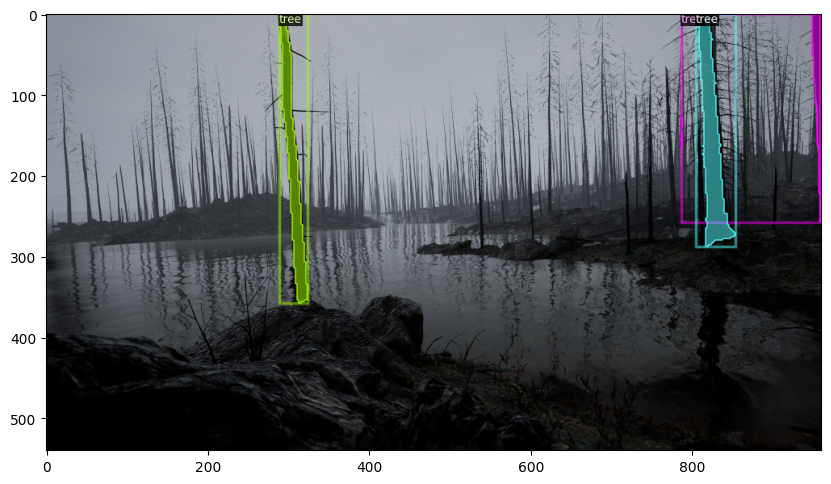

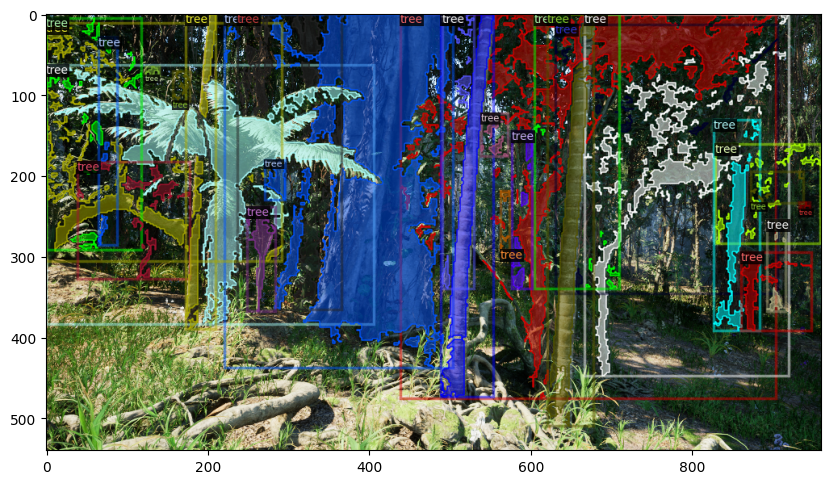

In [105]:
def show_one_batch(train_metadata, train_dataset_dicts, bgr=False):
    # Visualize some random samples
    # train_metadata      = MetadataCatalog.get("spread_train")
    # train_dataset_dicts = DatasetCatalog.get ("spread_train")
    for d in random.sample(train_dataset_dicts, 2):
        img = cv2.imread(d["file_name"])
        if bgr:
            img = img[:, :, ::-1]
        visualizer = Visualizer(img, metadata=train_metadata, scale=1)
        vis_img    = visualizer.draw_dataset_dict(d)
        out_img    = vis_img.get_image()[:, :, ::-1]
        dbgprint(train, LogLevel.TRACE, f'{out_img.shape = } - {out_img.dtype = } - {out_img[out_img!=0][:50]}')
        #plt.imshow(out_img)
        #plt.show(36,20)
        cv2_imshow(out_img)

show_one_batch(train_metadata, train_dataset_dicts, bgr=True)

trainer.train()

[21:22:13.647][INFO   ] - [TRAIN     ] image_dict.keys() = dict_keys(['file_name', 'height', 'width', 'image_id', 'image', 'padding_mask', 'instances'])
[21:22:13.647][INFO   ] - [TRAIN     ] type(image_dict["instances"]) = <class 'detectron2.structures.instances.Instances'> - len(image_dict["instances"]) = 65
[21:22:13.658][INFO   ] - [TRAIN     ] image.shape = torch.Size([3, 1024, 1024]) - image.dtype = torch.uint8 - tensor([38, 38, 40, 45, 44, 39, 36, 34, 34, 35, 41, 48, 47, 46, 40, 35, 36, 38,
        42, 42, 37, 34, 38, 37, 30, 31, 39, 40, 37, 43, 50, 46, 40, 40, 41, 43,
        44, 46, 44, 32, 24, 27, 29, 28, 26, 25, 25, 26, 27, 29],
       dtype=torch.uint8)
[21:22:13.661][INFO   ] - [TRAIN     ] k = 'gt_boxes' - 65 items
[21:22:13.661][INFO   ] - [TRAIN     ] k = 'gt_classes' - 65 items
[21:22:13.661][INFO   ] - [TRAIN     ] k = 'gt_masks' - 65 items


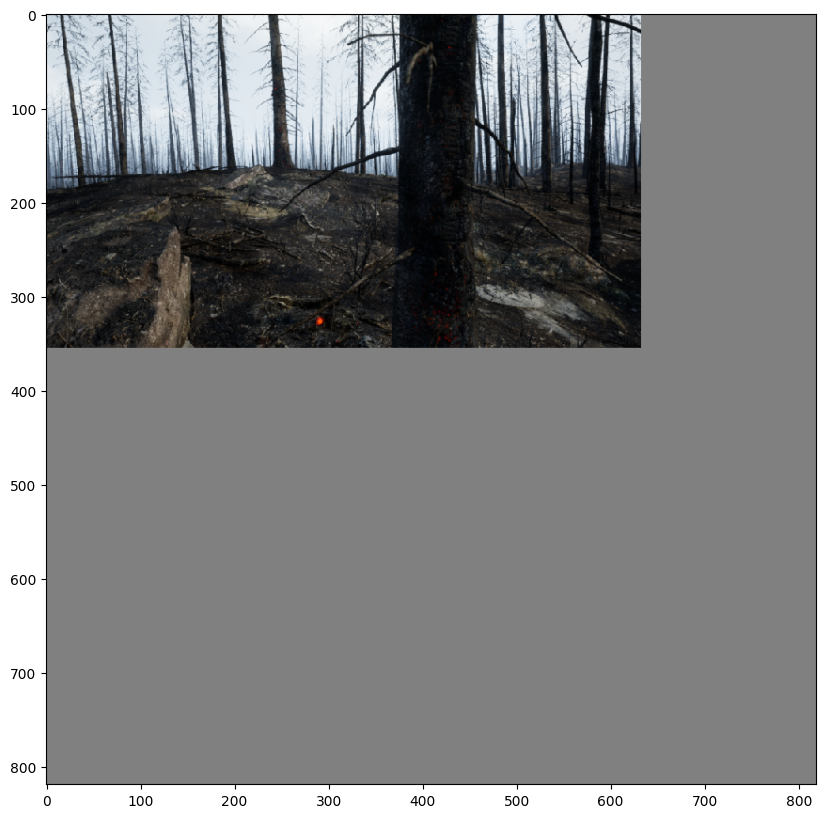

In [82]:
def show_one_batch2():
    one_batch = next(trainer.data_loader.__iter__())
    idx = random.randint(0, len(one_batch)-1)
    image_dict = one_batch[idx]
    dbgprint(train, LogLevel.INFO, f'{image_dict.keys() = }')
    dbgprint(train, LogLevel.INFO, f'{type(image_dict["instances"]) = } - {len(image_dict["instances"]) = }')
    image, masks_gt = image_dict['image'], image_dict['instances']
    annotated_img = draw_instance_predictions(image, masks_gt)
    cv2_imshow(annotated_img)
show_one_batch2()